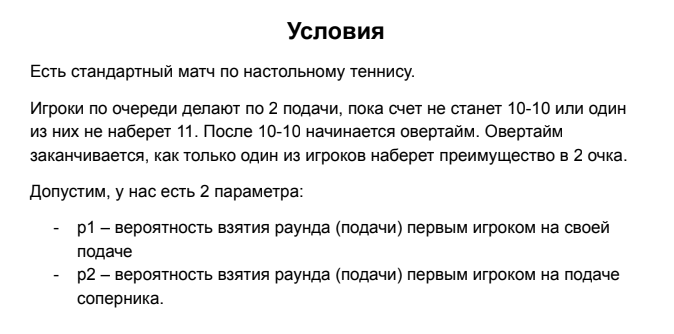


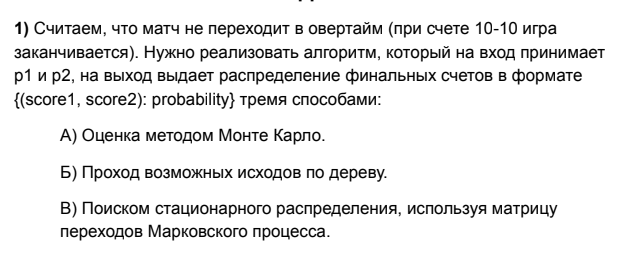

In [136]:
import numpy as np
import random
import operator

Наиболее простым методом для решения данной задачи, является метод Монте-Карло. Сложность данного алгоритма(реализованого мною) проще чем у остальных методов. Но метод Монте-Карло нуждается в большем обьеме времени для компиляции(если нам нужен результат максимально точный)

In [137]:
def Monte_Carlo(p1,p2):
    # Инициалиация массива со всеми результатами, количество итераций массива    
    num = 100000
    score_list = np.array([],dtype=int)
    for i in range(num):
        score = np.array([0,0],dtype=int)
        сheck = random.getrandbits(1)
        while(True):
            ch1 = np.random.random_sample()
            ch2 = np.random.random_sample()
            # первая подача игрока
            if (сheck): 
                if ch1<=p1:
                    score[0]+=1
                else: score[1]+=1
            else:
                if ch1<=p2:
                    score[0]+=1
                else: score[1]+=1
            # 
            if (score[0]>=11) or (score[1]>=11)or ((score[1]==10 and score[0]==10)):
                score_list = np.concatenate((score_list,score))
                break
            # вторая подача игрока
            if (not сheck): 
                if ch2<=p1:
                    score[0]+=1
                else: score[1]+=1
            else:
                if ch2<=p2:
                    score[0]+=1
                else: score[1]+=1
            # 
            if (score[0]>=11) or (score[1]>=11) or ((score[1]==10 and score[0]==10)):
                score_list = np.concatenate((score_list,score))

                break
            operator.not_(сheck)
    
    score_list = score_list.reshape((num,2))
    
    # Разделение на массив(счет) и шанс выпадения данного результат
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability = float(np.amax(frequency_list))/num
    
    return [result, probability]

In [420]:
b = Monte_Carlo(0.9,0.5)
print(b)

[[11, 4], 0.17667]


## Матрица переходов Марковского процесса

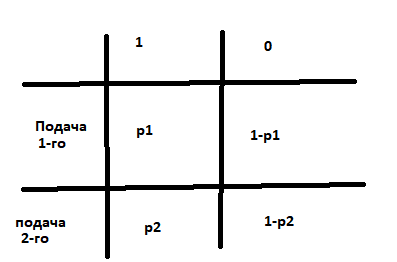

Сверху схематическое изображение матрицы получения победного очка за раунд первым игроком. Здесь я задействовал цикл для решения задачи более реалистичным способом, таким образом каждый при разыгровке раунда программа обращается к матрице. Но в теории, можно обойтись без многоразовых повторений партий так как для максимально точного определения, можно было просто выбрать наибольшую вероятность выиграша при подаче определенным игроком(так работает, только если один игрок имеет больший шанс как при подаче своей так и при приеме чужой, иначе обращаемся к циклу)

In [421]:
def Marcov_chain(p1,p2):
# Инициалиация массива со всеми результатами, количество итераций массива    
    score_list = np.array([],dtype=int)
    num = 100000
    
    results = np.array([1,0])
    #  Матрица переходов
    t_matrix = np.array([[p1,1-p1],[p2,1-p2]])

    for i in range(num):
        score = np.array([0,0])
        choice = random.getrandbits(1)
        while (True):
# Рассчет первой подачи определенного игрока
            inning1 = np.random.choice(results,p=t_matrix[1-choice])
            if (inning1):
                score[0]+=1
            else: score[1]+=1

            if (score[0]>=11) or (score[1]>=11):
                score_list = np.concatenate((score_list,score))
                break
# Рассчет второй подачи определенного игрока
            inning2 = np.random.choice(results,p=t_matrix[1-choice])
            if (inning2):
                score[0]+=1
            else: score[1]+=1

            if (score[0]>=11) or (score[1]>=11) or ((score[1]==10 and score[0]==10)):
                score_list = np.concatenate((score_list,score))
                break
            choice = 1-choice

        
    score_list = score_list.reshape((num,2))
    
    # Разделение на массив(счет) и шанс выпадения данного результат
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability = float(np.amax(frequency_list))/num


    return [result, probability]

In [422]:
b = Marcov_chain(0.9,0.6)
print(b)

[[11, 3], 0.20063]


## Проход возможных исходов по дереву

По идее, данный метод можено реализовать в sklearn с помощью какого-нибудь Decisiontree, но я решил попробовать вручную. Метод самый затратный, но таким образом он не уступает в точности другим. А если и вовсе построить бинарное дерево с вероятностями в конце веток, то можно было бы после ~1000-й итерации не заморачиваться над скоростью просчитываний и обращаться к любому узлу

Ну и конечно же, использование рекурсии и добавление еще одной функции сказываются на обьеме памяти и загруженности процессора

In [423]:
#Узел дерева  
def node(p1,p2,count):
            choice = np.random.random()
            # условие на выход  при окончании матча
            if (count[1,0]>=11) or (count[1,1]>=11) or ((count[1,1]==10 and count[1,0]==10)):
                        return count
            # проверка на подачи
            if ((count[1,0]+count[1,1])%4==0) or ((count[1,0]+count[1,1])%4==1):
              #решение забил или нет, и в последующем вызов этой же функции, но уже с измененным счетом  
                if (choice<=p1):
                    count[1,np.argmax(count[0])]+=1
                    count = node(p1,p2,count) 
                else:
                    count[1,np.argmin(count[0])]+=1
                    count= node(p1,p2,count)
            else:
                if (choice<=p2):
                    count[1,np.argmax(count[0])]+=1
                    count = node(p1,p2,count)
                else:
                    count[1,np.argmin(count[0])]+=1
                    count = node(p1,p2,count)
            
            return count

In [426]:
def Tree_Observation(p1,p2):
    #инициализация
    score_list = np.array([],dtype=int)
    num = 100000

    
    for i in range(num):
        # выбор: кто из игроков подаст первым
        choice = np.random.choice([True,False])
        if (choice):
            score=node(p1, p2, np.array([[-1,-2],[0,0]]))
            score=score[1]
            
        else:
            score = node(p2, p1, np.array([[-2,-1],[0,0]]))
            score = score[1,::-1]
        score_list = np.concatenate((score_list,score))

    
    score_list = score_list.reshape((num,2))
    # frequency part
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability_last = float(np.amax(frequency_list))/num


    
    return [result, probability_last]   


In [427]:
b = Tree_Observation(0.9,0.6)
print(b)

[[11, 3], 0.19792]


# Раздел 2. Овертайм

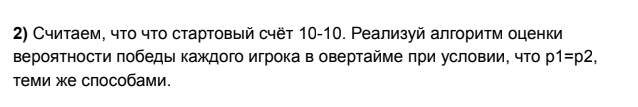

Метод Монте-Карло как и все последующие выдают точный результат, но я бы поменял статистику и вероятности, ведь 2 параметров для подсчета результата в овертайме недостаточно. На 2 параметрах сложно выудить разницу в эфективности трех методов, но точно можно сказать, что при р1=р2, если хоть у одного игрока будем преимущество на 0.01, то при большом количестве итераций результат будет 12:10

In [373]:
def Overtime_Monte_Carlo(p1):

    num = 10000
    score_list = np.array([],dtype=int)
    for i in range(num):
        score = np.array([10,10],dtype=int)
        while(True):
            ch1 = np.random.random_sample()
            # подача игрока
            if ch1<=p1:
                score[0]+=1
            else: score[1]+=1

            # 
            if (score[0]-score[1]==2)or (score[0]-score[1]==-2):
                score_list = np.concatenate((score_list,score))
                break
    
    score_list = score_list.reshape((num,2))
    
    # frequency part
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability = float(np.amax(frequency_list))/num
    
    return [result, probability]

In [375]:
a = Overtime_Monte_Carlo(0.6)
print(a)

[[12, 10], 0.3622]


In [376]:
def Overtime_Marcov_chain(p1):

    
    score_list = np.array([],dtype=int)
    results = np.array([1,0])
    t_matrix = np.array([p1,1-p1])
    num = 1000
    for i in range(num):
        score = np.array([10,10])

        while (True):
            inning = np.random.choice(results,p=t_matrix)
            if (inning):
                score[0]+=1
            else: score[1]+=1

            if (score[0]-score[1]==2)or (score[0]-score[1]==-2):
                score_list = np.concatenate((score_list,score))
                break
      
    score_list = score_list.reshape((num,2))
    
    # frequency part
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability = float(np.amax(frequency_list))/num
#     print(score_list)

    return [result, probability]

In [388]:
b = Overtime_Marcov_chain(0.6)
print(b)

[[12, 10], 0.359]


In [411]:
def over_node(p1,count):
            choice = np.random.random()
            if (count[0]-count[1]==2)or (count[0]-count[1]==-2):
                return count
                
            if (choice<=p1):
                count[0]+=1
                count = over_node(p1,count) 
            else:
                count[1]+=1
                count= over_node(p1,count)

            
            return count

In [412]:
def Overtime_Tree_Observation(p1):
    score_list = np.array([],dtype=int)
    num = 5000

    
    for i in range(num):
        score = over_node(p1,np.array([10,10]))
        score_list = np.concatenate((score_list,score))

    
    score_list = score_list.reshape((num,2))
    # frequency part
    unique_list, frequency_list = np.unique(score_list,return_counts=True,axis = 0)
    result = unique_list[np.argmax(frequency_list)].tolist()
    probability_last = float(np.amax(frequency_list))/num


    
    return [result, probability_last]   


In [419]:
b = Overtime_Tree_Observation(0.6)
print(b)

[[12, 10], 0.3472]


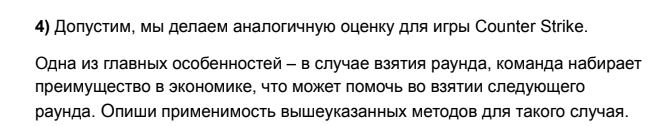

### Cs сравнение

Первое что приходит в голову, матрица переходов Марковского процесса будет выглядеть максимально заполненой в  данном примере, ведь Марковский процесс будет учитывать только соседние раунды. Проход по деревьям займет больше времени и само дерево увеличится, точность не ослабится. Монте-Карло тоже не будет бесполезным, просто все будет зависеть от количества итераций, но мне кажется это не то к чему стоит стремиться. Итог: при таких условях, когда важен только соседний раунд, Марковский процесс будет максимально подходящим, но стоит учитывать, что в игре CS экономическое преимущество меняется каждый раунд в зависимости от количества от очереди побед, таким образом матрица бы стремительно увеличивалась